### Instrucciones generales <a class="tocSkip"></a>

1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)



# Tarea 2: Filtrado de señales

## Introducción


Un **electrocardiograma (ECG)** es un gráfico de voltaje (amplitud) en función del tiempo correspondiente a la actividad eléctrica del corazón. Cada etapa del ciclo cardíaco es representado por una letra: **P, Q, R, S y T**. La siguiente figura muestra un esquema de un ECG con dos pulsos.

<img src="cardio.png" width="600">


El ECG se usa para hacer diagnósticos y en particular para analizar la existencia de anormalidades en el ciclo cardiaco. La **frecuencia cardiaca**, es decir el inverso del intervalo RR, de un humano normal en reposo está en el rango de **60 y 100 latidos por minuto**



## Enunciado

El hospital base de Valdivia tiene un electrocardiógrafo que mide la ECG en miliVolts [mV] a una frecuencia de muestreo de $360$ [Hz]

Durante el proceso de captura ciertos errores provocaron que la señal se contamine con 

- **(A)** Un ruido asociado al sistema eléctrico
- **(B)** Un ruido de baja frecuencia causado por un desperfecto del sensor
- **(C)** Un ruido blanco de origen térmico 

Esto complica el análisis del médico por lo que el hospital base los contrata a ustedes para **diseñar un filtro que limpie la señal ECG**

Resuelva las actividades que se piden a continuación, respondiendo y analizando donde corresponda

<IPython.core.display.Javascript object>


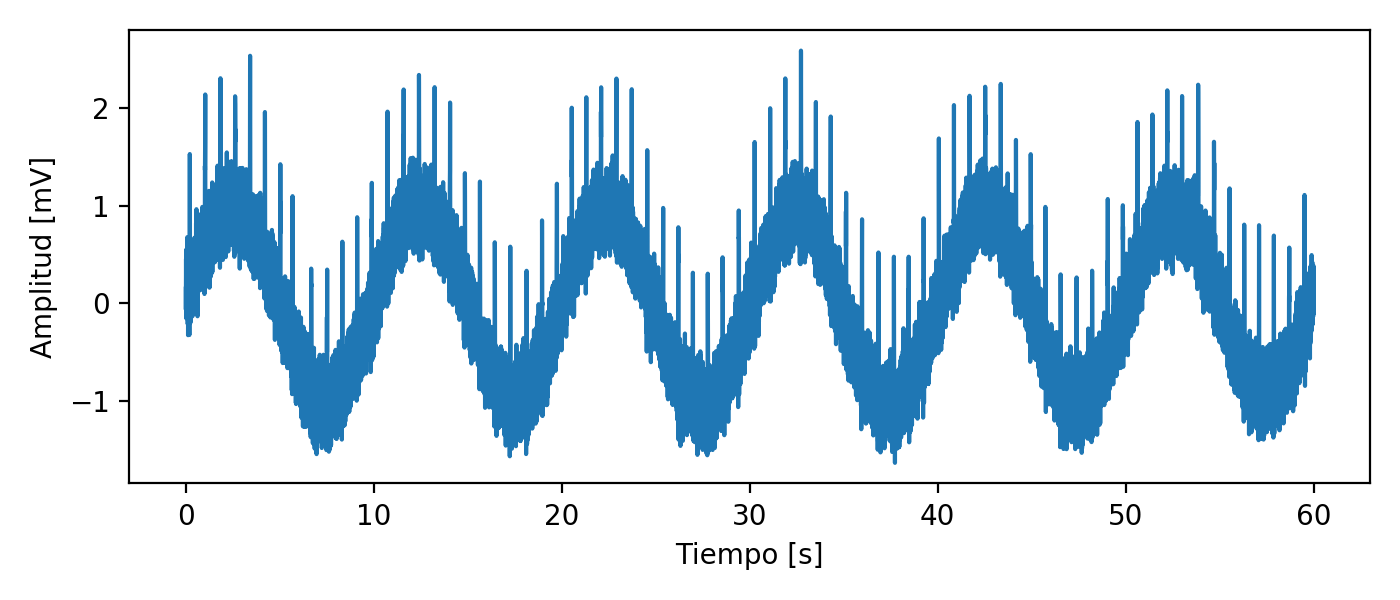

In [1]:
%matplotlib notebook
import numpy as np
import pickle
import matplotlib.pylab as plt

import scipy.fft as sfft
import scipy.signal

with open("ECG.pkl", "rb") as f:
    data = pickle.load(f)

Fs = 360
N = len(data)
time = np.arange(N)/Fs
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.plot(time, data)
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Amplitud [mV]');

## Análisis (15%)

- Observe los primeros dos segundos de la señal, compare con el esquema mostrado en la introducción y discuta sobre los efectos causados por los ruidos **A**, **B** y **C** mencionados en el enunciado. Además responda  ¿Qué es un ruido blanco y que tipo de efecto introduce en la señal y en su espectro? ¿Qué es una tendencia y que tipo de efecto introduce en la señal y su espectro? 

Si convertimos las pulsaciones cardiacas por minuto de una persona en reposo a hz, obtenemos un rango frecuencias entre 1hz a 1.6hz, y en consecuencia un rango de periodos entre 0.6 a 1 segundos por latido. 

Al analizar los primeros dos segundos de la señal, podemos inferir que los picos más altos representan a las etapas **QRS** de un ciclo caridaco, ya que la distancia temporal entre picos se encuentra dentro del rango antes mencionado, sin embargo el resto de las etapas tales como **P** y **T** no son directamente visibles debido a la cantidad de ruido en la señal.

También podemos observar que, a diferencia del esquema, los pulsos no están centrados al eje de amplitud 0, sino que van en aumento. Si alejamos el zoom podemos inferir que se debe al ruido de baja frecuencia ( señal sinusoidal de 0.1 hz aprox ) causado por el desperfecto en el sensor.

Otro aspecto que podemos notar es que existe una componente con amplitud cercana a 0.5 mV cuya frecuencia es aproximadamente 60 hz, la cual pensamos que es introducida por el sistema eléctrico, ya que la frecuencia de la corriente alterna suele ser de 50 o 60 hz.

El ruido blanco hace alusión al espectro electromagnetico visible, donde la luz blanca es la mezcla de todos los colores, por lo tanto un ruido blanco esta compuesto por componentes de todas las frecuencias, pero donde estas tienen igual amplitud.
Si analizamos una señal de ruido blanco, vemos que representa un proceso estocástico, ya que no existe coorelación entre instantes, sin embargo, si analizamos su espectro vemos que posee igual intensidad en todas sus frecuencias.

Como ya hemos detectado tendencias claramente visibles en la señal, podemos inferir que la cantidad de ruido blanco de origen térmico debe ser de intensidad muy baja.

Una tendencia en una señal, sería lo contrario a un proceso estocástico, ya que indica la presencia de correlación entre instantes. Por ejemplo la señal del ECG muestra una clara tendencia en las frecuencias bajas, probablemente por el ruido intruducido por desperfecto en el sensor.
En cuanto al espectro, una tendencia es notable cuando existen frecuencias con mayor amplitud que el resto, lo contrario al ruido blanco.


- Calcule y muestre gráficamente el valor absoluto de la transformada de Fourier de la señal en función de la frecuencia y su espectrograma en función del tiempo y la frecuencia. Para el espectrograma decida el largo de ventana, traslape y tipo de ventana. Justifique su elección tomando en consideración el rango de frecuencias de un paciente normal y los *trade-off* aprendidos en clases

<IPython.core.display.Javascript object>


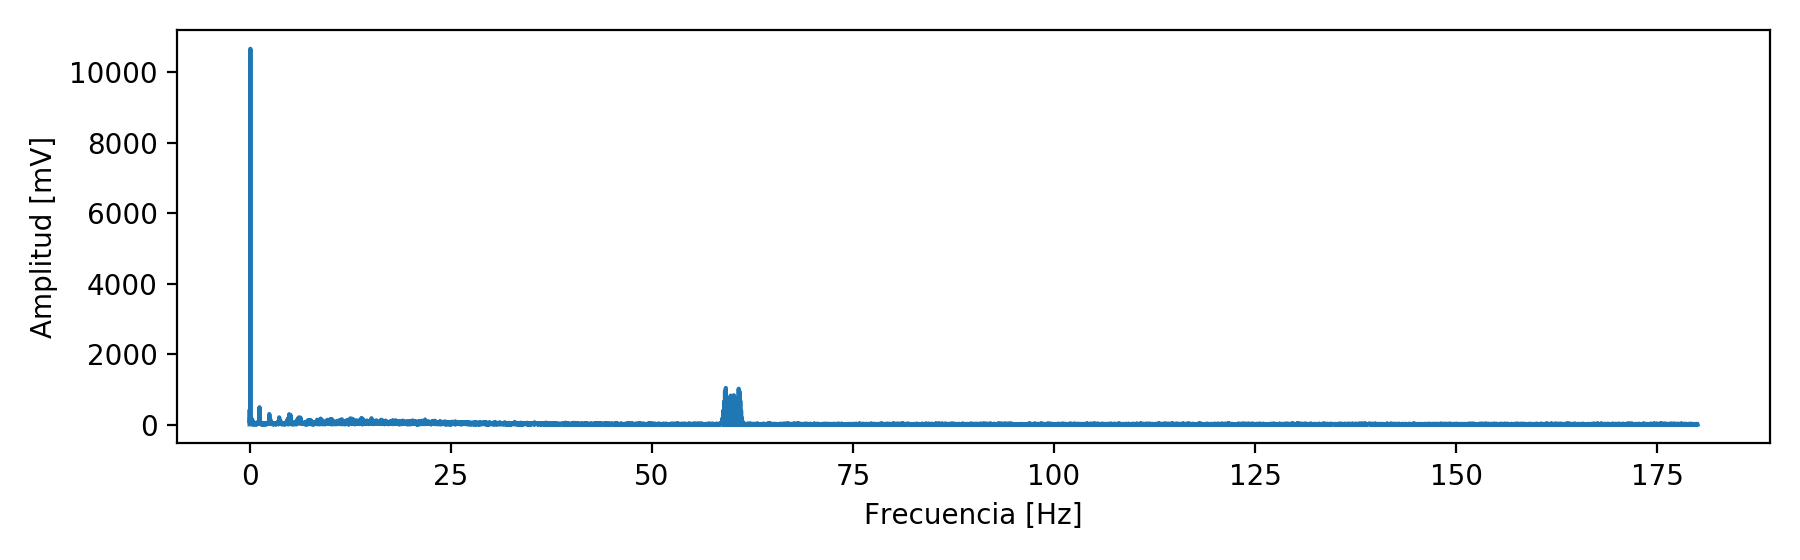

In [2]:
# Calculamos transformada de fourier a la señal completa
DATA = np.absolute(sfft.rfft(data))
freqs = sfft.rfftfreq(N,1.0/Fs)

# Graficamos el espectro
fig, ax = plt.subplots(figsize=(9, 2.8), tight_layout=True)
ax.plot(freqs, DATA); 
ax.set_ylabel('Amplitud [mV]');
ax.set_xlabel('Frecuencia [Hz]');

Para implementar el espectrograma, seleccionamos un largo de ventana con la suficiente resolución temporal para poder diferenciar los latidos, como el periodo de estos ronda entre 0.6 a 1 segundos, si obtenemos el promedio y lo multiplicamos por la frecuencia de muestreo, obtenemos un tamaño de 288 muestras. Por lo tanto sacrificamos un poco de resolución en frecuencia, a cambio de una mejor resolución temporal.
Respecto al traslape, probamos con distintas cantidades, obteniendo una mejor resolución temporal con 192 muestras.
Dado que el ruido de baja frecuencia es menor a 1 hz, deberíamos aumentar demasiado el tamaño de la ventana para poder diferenciarlo de los latidos frecuencialmente, por lo tanto decidimos enfocarnos simplemente en poder visualizar los cambios de amplitud de latidos en el tiempo, ya que conocemos su rango de frecuencias. Dicho esto, seleccionamos la ventana blackman, la cual, al tener una curva muy suave, elimina los lóbulos laterales, pero ensancha los principales. Esto no es un problema en este caso ya que (dejando el rudio de baja frecuencia a un lado) las frecuencias de latidos se encuentran alejadas a las del ruido del sistema eléctrico.

<IPython.core.display.Javascript object>


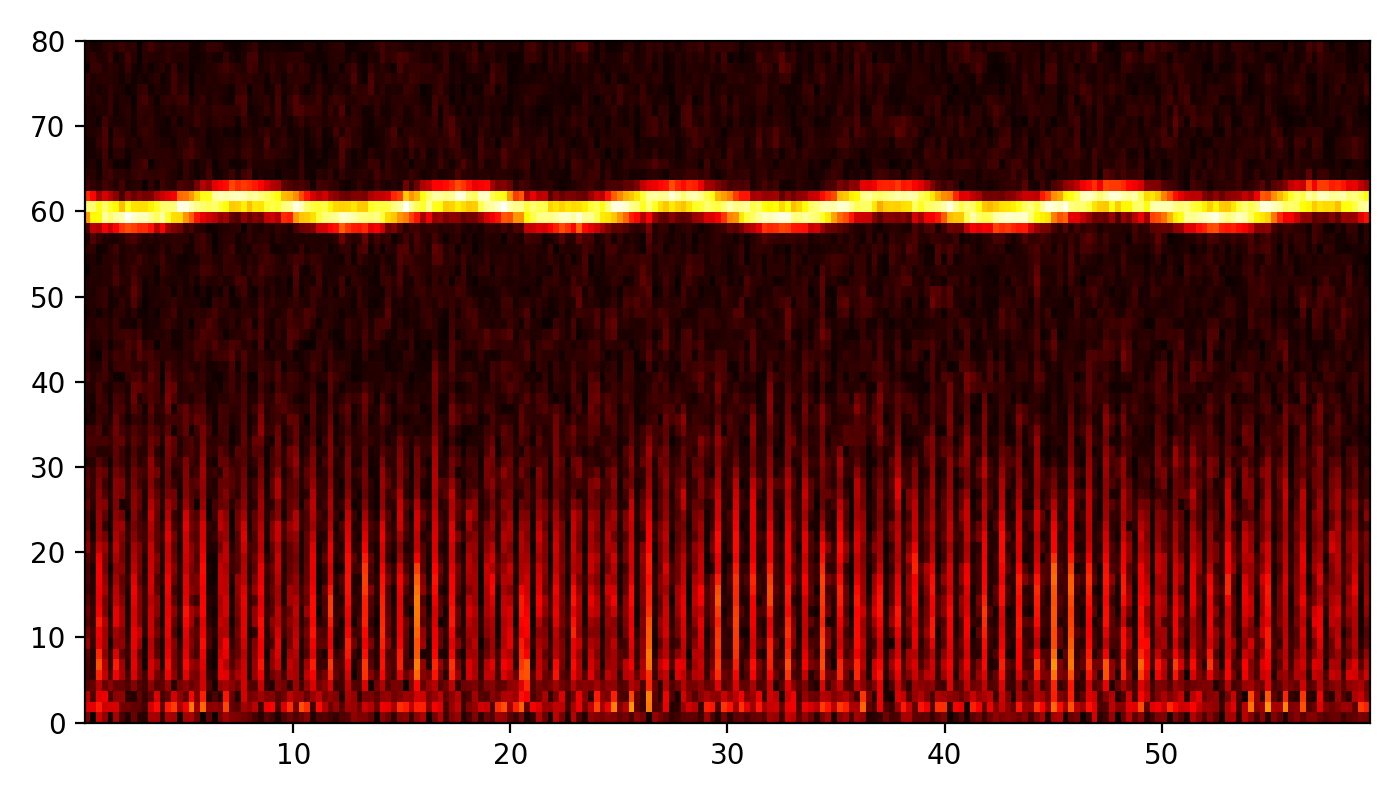

(0, 80)

In [3]:
fig, axs = plt.subplots(1,1,figsize=(7, 4),sharey=True,tight_layout=True)

wSize = 288
freqs, times, Sxx = scipy.signal.spectrogram(
    data, 
    fs=Fs,
    nperseg = wSize,
    noverlap = wSize/1.5,
    window='blackman',
    scaling='density',
    mode='magnitude'
)

# Overlap mejora un poco la resolucion en el tiempo
axs.pcolormesh(times, freqs, Sxx,cmap='hot', shading='auto')
axs.set_ylim([0,80])
#axs[1].pcolormesh(times, freqs, np.log10(Sxx+1e-20),cmap='inferno', shading='auto'); 

- En base a la señal, su espectro de magnitud y su espectrograma identifique la frecuencia central o el rango de frecuencias asociada a las tres fuentes de ruido. ¿En qué rango de frecuencias (Hz) se espera encontrar la señal de ritmo cardíaco de un humano normal en reposo?

**Ruido Sistema Eléctrico**

Este ruido se puede visualizar fácilmente tanto con el espectro como en el espectrograma, se observa que su frecuencia central es de 60hz, pero varía sinusoidalmente entre 58 y 62 hz.

**Ruido Desperfecto Sensor**

Este ruido es claramente visible en el espectro ya que posee gran amplitud, y marca la tendencia principal de la señal, su frecuecia es de 0.1 hz y es estable.

**Ruido Origen Térmico**

Este no es tan visible como los anteriores, tanto en la señal, su espectro y espectrograma. Al ser supuestamente ruido blanco, no pareciera mostrar una tendencia, por lo tanto no tiene una frecuencia central, sin embargo se podría decir que su rango de frecuencias es de 0 a 180 hz

**Ritmo Cardiaco**
Se espera encontrar entre 1 y 1.6 hz, sin embargo analizando el espectro y espectograma, creemos que existen armónicos hasta aproximadamente 40hz.

## Filtrado FIR (50%)

Describa lo que es un filtro FIR, explique paso a paso el método de enventanado y describa los argumentos y el valor de retorno de la función `scipy.signal.firwin`. 

Luego use este método para diseñar y aplicar tres filtros sobre la señal de entrada. El primero debe filtrar el ruido **(A)**, el segundo el ruido **(B)** y el tercero el ruido **(C)**. Indique la(s) frecuencia(s) de corte y el tipo de filtro en cada caso. Justifique su elección en base a sus observaciones en el paso anterior.

Considere una ventana de Hamming y $1001$ coeficientes para el filtro

Por cada filtro:
- Muestre la respuesta al impulso y la respuesta en frecuencia resultantes
- Filtre la señal convolucionando con la respuesta al impulso
- Calcule la resta entre la señal original y la señal filtrada. ¿Qué espera observar en este caso? Luego muestre gráficamente el espectro de magnitud y el espectrograma de la señal restada. En base a lo que observa y a los gráficos del punto anterior discuta sobre la efectividad del filtro

Finalmente
- Filtre la señal convolucionando con los tres filtros. Muestre el resultado graficamente. 
- Muestre un acercamiento de los primeros tres segundos de la señal filtrada, reconozca la fase R y márquela con una linea roja punteada.
- Cree una función que mida el tiempo RR en la señal filtrada. Grafique la frecuencia cardiaca en función del tiempo. ¿Se encuentra la persona en el rango sano o no?

## Filtrado IIR (35%)

Describa los filtros IIR y compárelo con los filtros FIR. Describa los argumentos y el valor de retorno de la función `scipy.signal.iirfilter`.

Luego use este método para diseñar tres filtros. Los filtros deben cumplir el mismo propósito que en el caso anterior. Considere filtros IIR de tipo `butterworth` y todos del mismo orden. Aplique los filtros sobre la señal de entrada usando la función `scipy.signal.lfilter`.

El objetivo es encontrar el mínimo orden para los filtros IIR tal que el error medio cuadrático entre la señal filtrada IIR y la señal filtrada FIR sea menor que un 1% de la varianza de la señal filtrada FIR. Es decir que si $x$ es la señal filtrada IIR e $y$ es la señal filtrada FIR donde $N = \min(\text{len}(x), \text{len}(y))$ se cumpla que

$$
\sum_{i=1}^N (x_i - y_i)^2 < 0.01 \sum_{i=1}^N (y_i - \bar y_i)^2
$$

Finalmente, discuta sobre sus hallazgos muestre gráficamente el resultado del mejor filtro IIR
